In [1]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
print(pm.__version__)
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
#plt.rc('text', usetex=True)

3.0.rc4


# Data

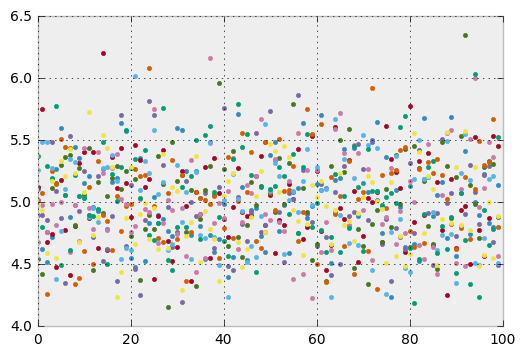

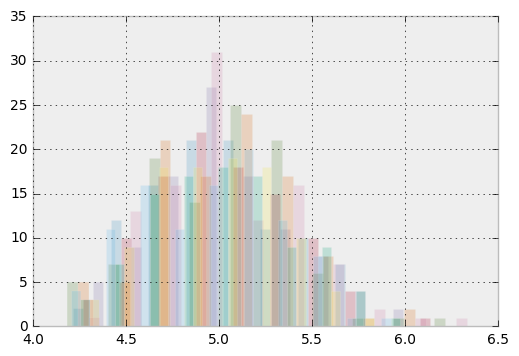

In [2]:
x = np.arange(100)
n = 3
y_mean = .5
y_std = 2
y_scale = y_mean**2/y_std
y_shape = y_std/y_mean
y = np.random.gamma(scale=y_scale, shape=y_shape, size=(len(x),n,n)) + 4
y = y + np.array([np.random.random(size=(n,n)) for i in range(len(x))])
for i in range(n):
    plt.plot(x, y[:,:,i], '.')
plt.figure()
bins = 10
for i in range(n):
    _ = plt.hist(y[:,:,i], bins=bins, alpha=.2)

# Model

In [3]:
last=False
def timing(reset=False):
    from datetime import datetime
    global last
    global startt
    if reset or not last:
        last = datetime.now()
        startt = datetime.now()
    else:
        duration = datetime.now() - last
        print('last:',duration.total_seconds(),'s')
        print('total:',(datetime.now() - startt).total_seconds(),'s')
        last = datetime.now()

In [4]:
# a cool model but very expensive ...
with pm.Model() as model:
    # starting with uniform distribution
    timing(True)
    alpha_base = pm.Uniform('alpha_base', lower=1, upper=3, shape=(1))
    alpha_delta = pm.Normal('alpha_delta', mu=3, sd=2, shape=(n,n))
    alpha = alpha_base + alpha_delta
    print("defined alpha vars")
    timing()
    
    beta_base = pm.Uniform('beta_base', lower=0, upper=1, shape=(1))
    beta_delta = pm.Normal('beta_delta', mu=3, sd=2, shape=(n,n))
    beta = beta_base + beta_delta
    print("defined beta vars")
    timing()
    
    Y = pm.Gamma('Y', alpha=alpha, beta=beta, observed=y)
    print("defined Y")
    timing()
    
    start = pm.find_MAP()    
    print("found start")
    timing()
    
    step = pm.NUTS()
    print("set NUTS")
    timing()
    
    trace = pm.sample(200, step, start=start, progressbar=True)
    timing()

defined alpha vars
last: 15.446536 s
total: 15.448482 s
defined beta vars
last: 0.572935 s
total: 16.022363 s
defined Y
last: 0.476618 s
total: 16.499706 s
Optimization terminated successfully.
         Current function value: 1215.218412
         Iterations: 47
         Function evaluations: 74
         Gradient evaluations: 66
found start
last: 37.443589 s
total: 53.944588 s


  0%|          | 0/200 [00:00<?, ?it/s]

set NUTS
last: 284.814804 s
total: 338.761996 s


100%|██████████| 200/200 [02:39<00:00,  2.89it/s]

last: 159.581972 s
total: 498.345997 s


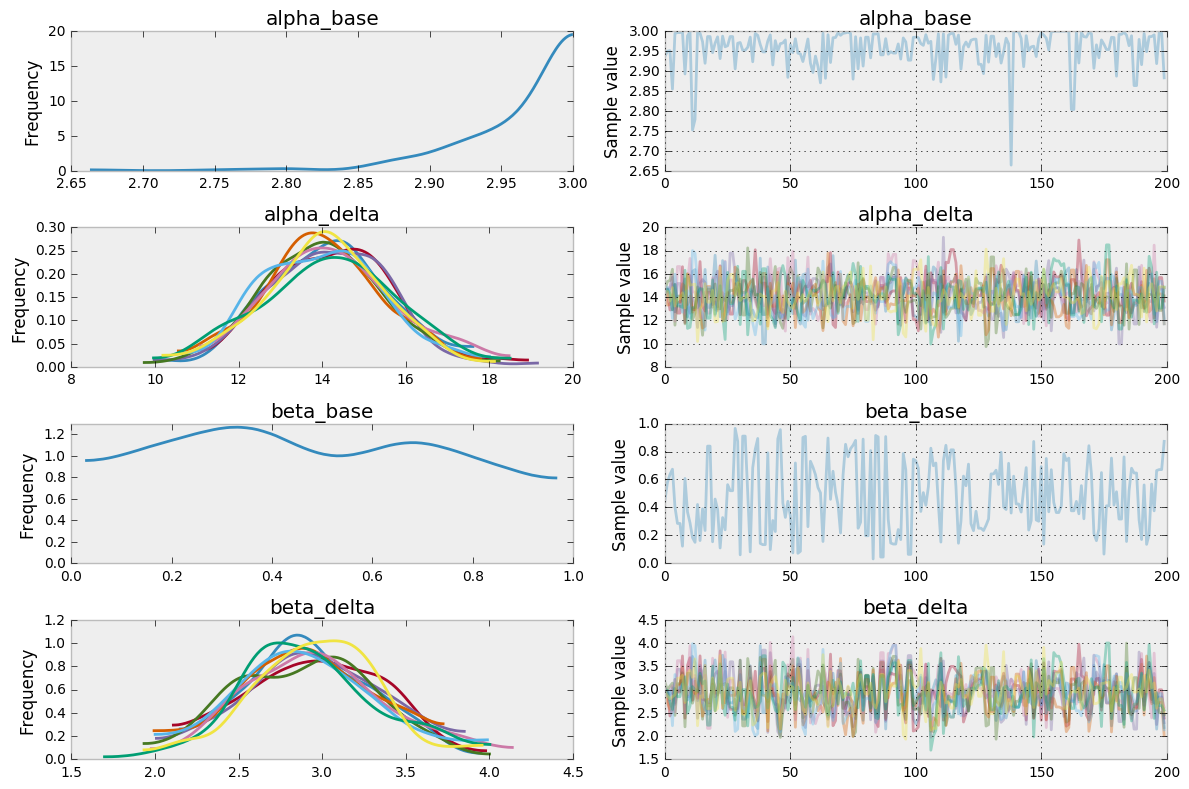

In [5]:
_ = pm.traceplot(trace, 
                 varnames=['alpha_base',
                           'alpha_delta',
                           'beta_base',
                           'beta_delta'])
#_ = pm.autocorrplot(trace, 
#                   varnames=['alpha', 'beta'])

# Simpler Model

In [6]:
# using old data and simpler model
with pm.Model() as model:
    timing(True)
    alpha = pm.Normal('alpha', mu=np.ones([n,n])*2, sd=np.ones([n,n]), shape=(n,n))
    print("defined alpha vars")
    timing()
    
    beta = pm.Normal('beta', mu=np.ones([n,n]), sd=np.ones([n,n]), shape=(n,n))
    print("defined beta vars")
    timing()
    
    Y = pm.Gamma('Y', alpha=alpha, beta=beta, observed=y)
    print("defined Y")
    timing()
    
    start = pm.find_MAP()    
    print("found start")
    timing()
    
    step = pm.NUTS()
    print("set NUTS")
    timing()
    
    trace = pm.sample(200, step, start=start, progressbar=True)
    timing()

defined alpha vars
last: 0.216328 s
total: 0.218246 s
defined beta vars
last: 0.105089 s
total: 0.327152 s


/usr/lib/python3.5/site-packages/pymc3/distributions/continuous.py:60: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
/usr/lib/python3.5/site-packages/pymc3/distributions/continuous.py:60: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


defined Y
last: 0.544701 s
total: 0.873953 s
Optimization terminated successfully.
         Current function value: 1547.016336
         Iterations: 36
         Function evaluations: 60
         Gradient evaluations: 51
found start
last: 6.334866 s
total: 7.21005 s


  0%|          | 0/200 [00:00<?, ?it/s]

set NUTS
last: 14.650746 s
total: 21.866466 s


100%|██████████| 200/200 [00:35<00:00,  5.64it/s]

last: 35.452404 s
total: 57.321372 s


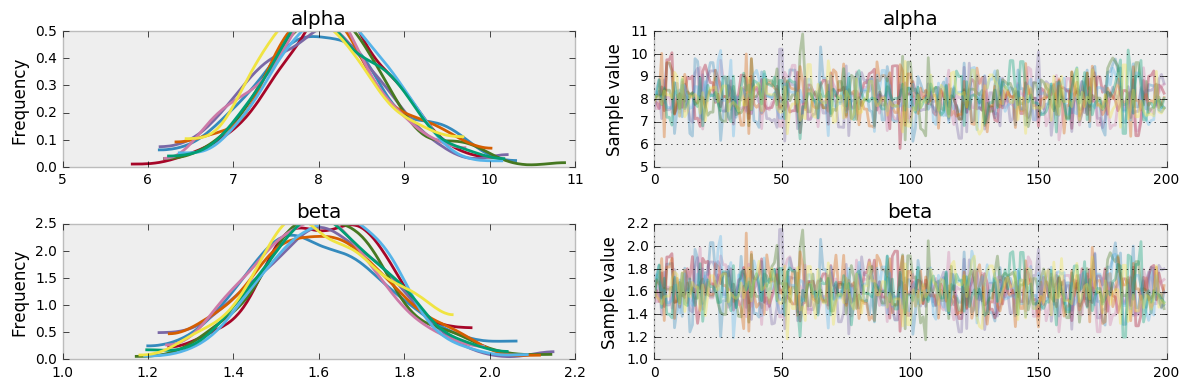

In [7]:
_ = pm.traceplot(trace, 
                 varnames=['alpha',
                           'beta'])

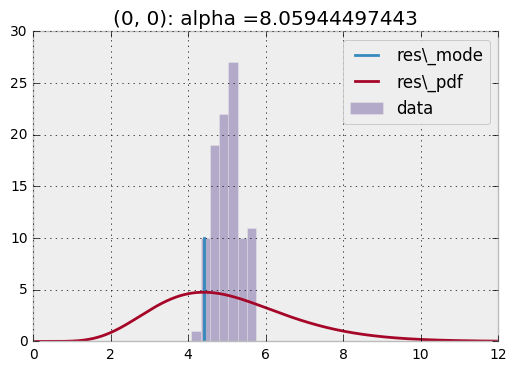

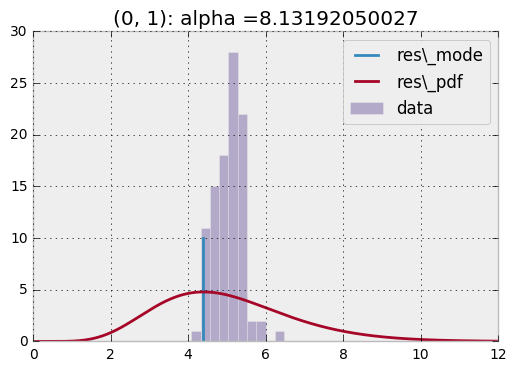

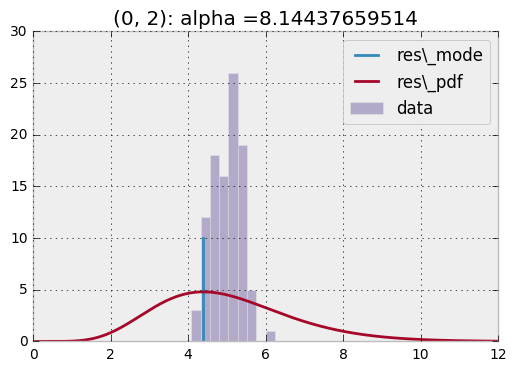

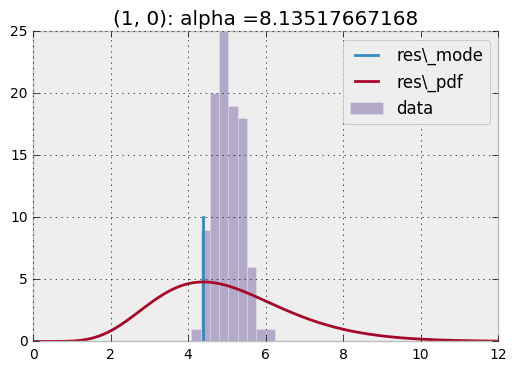

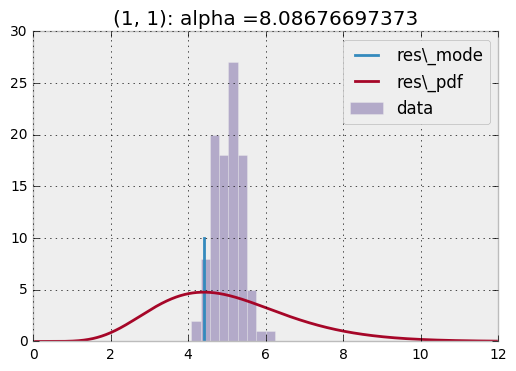

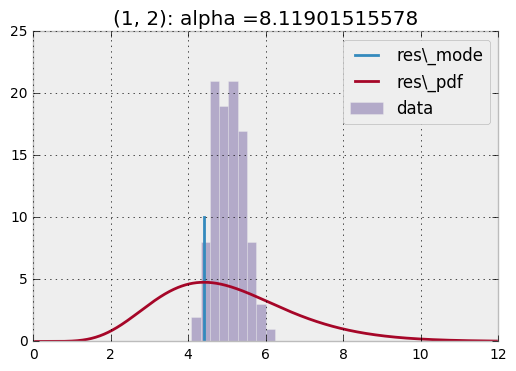

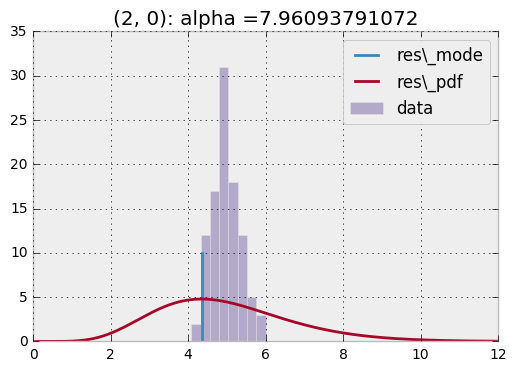

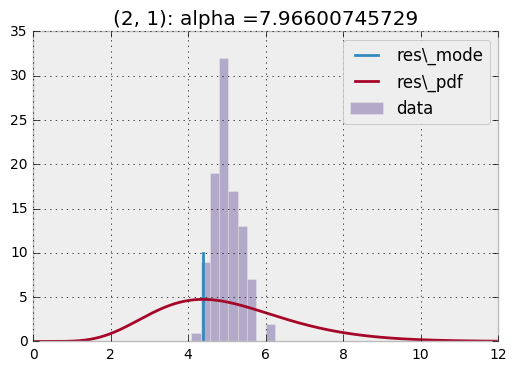

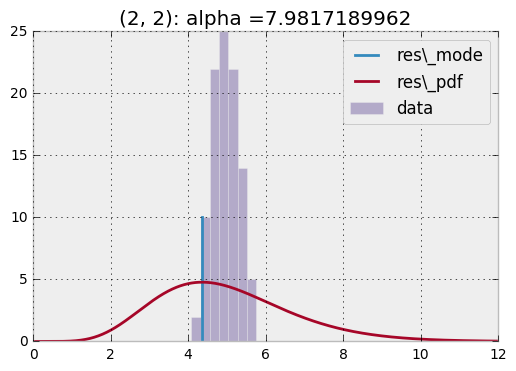

In [8]:
import matplotlib.mlab as mlab
import itertools

alpha_trace = trace.get_values('alpha')
beta_trace = trace.get_values('beta')

burnin = int(.1*len(alpha_trace))

alpha_mean = np.mean(alpha_trace, axis = 0)
alpha_std = np.std(alpha_trace, axis = 0)
assert np.shape(alpha_mean) == (n, n), "Wrong Dimensions"

beta_mean = np.mean(beta_trace, axis = 0)
beta_std = np.std(beta_trace, axis = 0)

mode = (alpha_mean - 1)/beta_mean

# shape
k_mean = alpha_mean
# scale
theta_mean = 1/beta_mean

assert np.shape(theta_mean) == np.shape(beta_mean), "Wrong Dimensions"

bins = 50
maxx = 12

x = np.linspace(0, maxx, 1000)

for i, j in itertools.product(range(n), repeat=2):
    plt.figure()
    m = np.mean(mode[i,j])
    plt.plot([m,m], [10,0])
    res = scipy.stats.gamma.pdf(x=x,
                                a=np.mean(k_mean[i,j]),
                                scale=np.mean(theta_mean[i,j]))
    plt.plot(x, res*20)  
    
    plt.hist(y[:,i,j], bins=bins, range=[0, 12], alpha=.5)
                          
    plt.legend(["res\_mode", 'res\_pdf', 'data'])
    plt.title('('+
              str(i)+
              ", "+
              str(j)+
              '): '+
              'alpha ='+
              str(np.mean(alpha_mean[i,j])))

# altering data ...

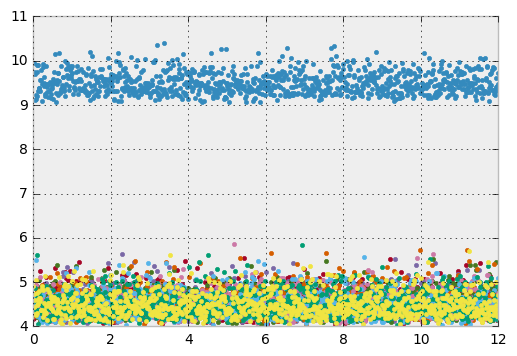

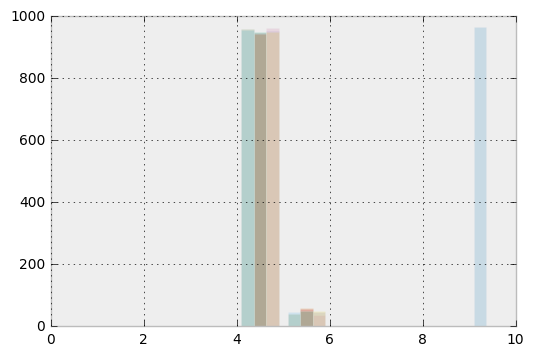

In [9]:
y = np.random.gamma(scale=y_scale, shape=y_shape, size=(len(x),n,n)) + 4
y[:,0,0] = y[:,0,0] + 5
for i in range(n):
    plt.plot(x, y[:,:,i], '.')
plt.figure()
bins = 10
for i in range(n):
    _ = plt.hist(y[:,:,i], bins=bins, alpha=.2, range=[0,10])

In [10]:
# using new data and simpler model
with pm.Model() as model:
    timing(True)
    alpha = pm.Normal('alpha', mu=alpha_mean, sd=alpha_std, shape=(n,n))
    print("defined alpha vars")
    timing()
    
    beta = pm.Normal('beta', mu=beta_mean, sd=beta_std, shape=(n,n))
    print("defined beta vars")
    timing()
    
    Y = pm.Gamma('Y', alpha=alpha, beta=beta, observed=y)
    print("defined Y")
    timing()
    
    #start = pm.find_MAP()    
    print("found start")
    timing()
    
    #step = pm.NUTS()
    print("set NUTS")
    timing()
    
    trace = pm.sample(200, step, start=start, progressbar=True)
    timing()

defined alpha vars
last: 0.1188 s
total: 0.11957 s
defined beta vars
last: 0.12697 s
total: 0.247845 s


/usr/lib/python3.5/site-packages/pymc3/distributions/continuous.py:60: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
/usr/lib/python3.5/site-packages/pymc3/distributions/continuous.py:60: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
Assigned NUTS to alpha
Assigned NUTS to beta


defined Y
last: 0.635034 s
total: 0.884365 s
found start
last: 0.000223 s
total: 0.885874 s
set NUTS
last: 0.000236 s
total: 0.887344 s


100%|██████████| 200/200 [00:11<00:00, 16.91it/s]

last: 23.775753 s
total: 24.664839 s


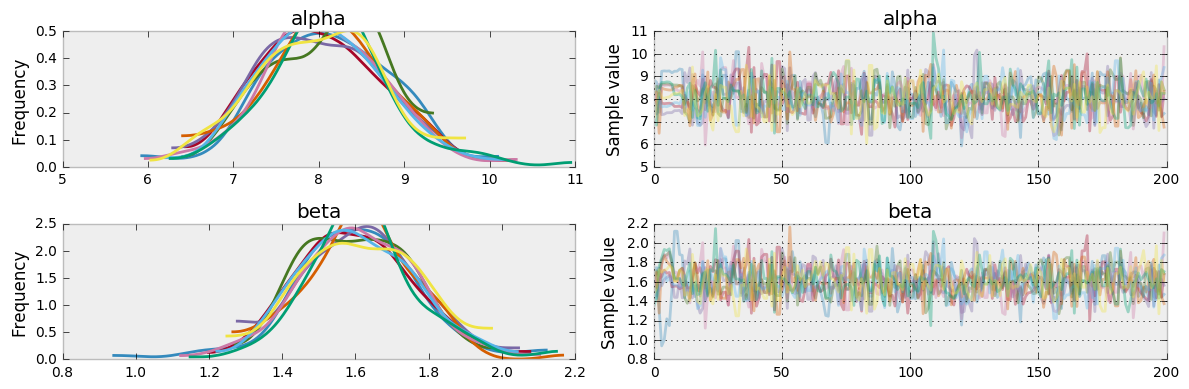

In [11]:
_ = pm.traceplot(trace, 
                 varnames=['alpha',
                           'beta'])

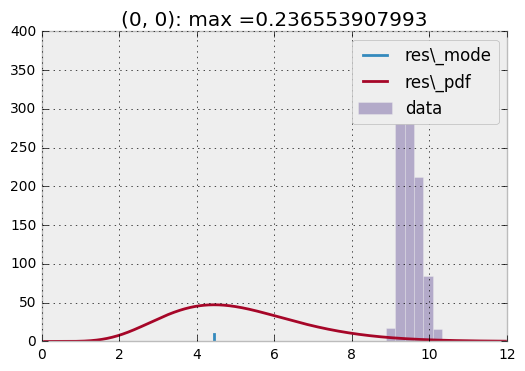

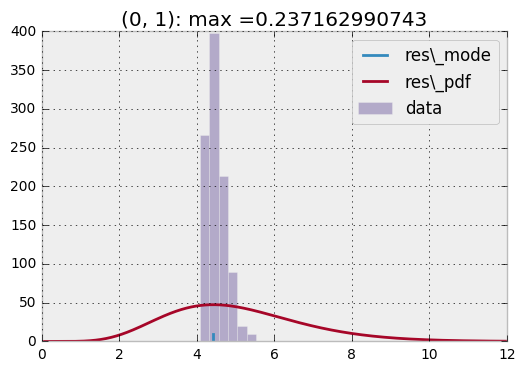

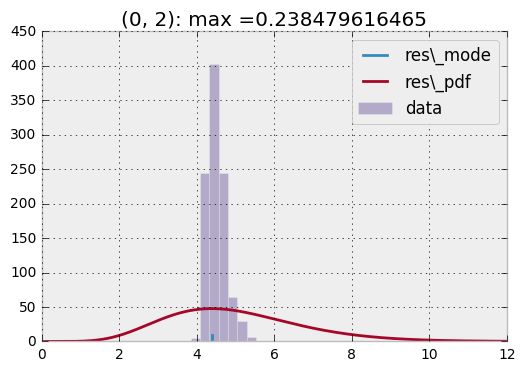

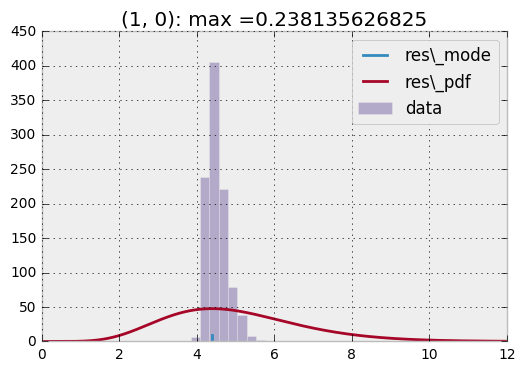

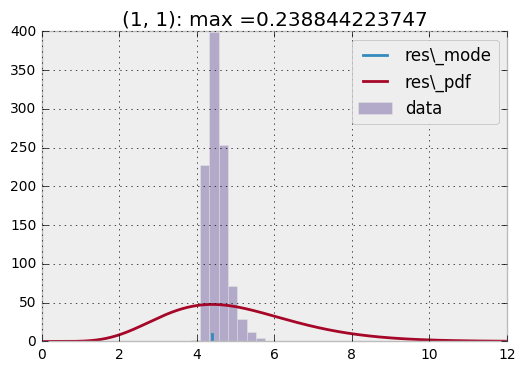

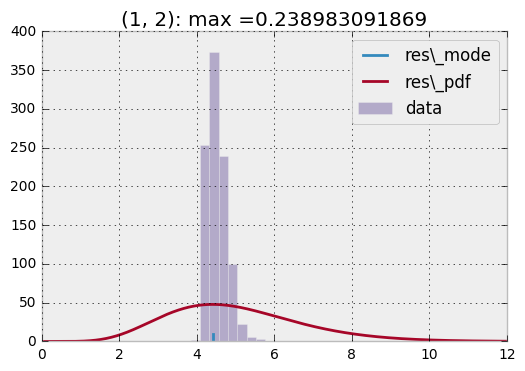

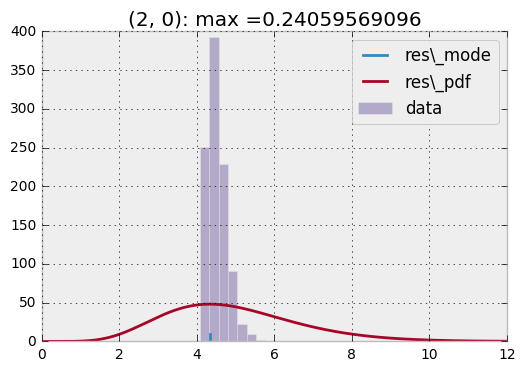

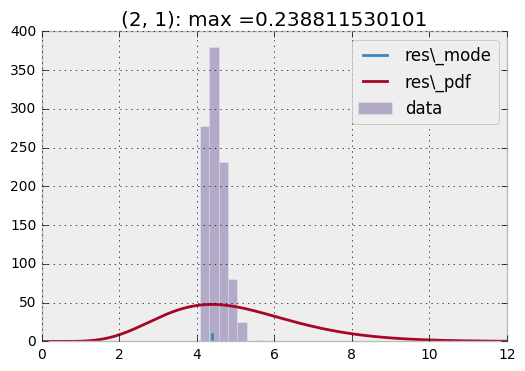

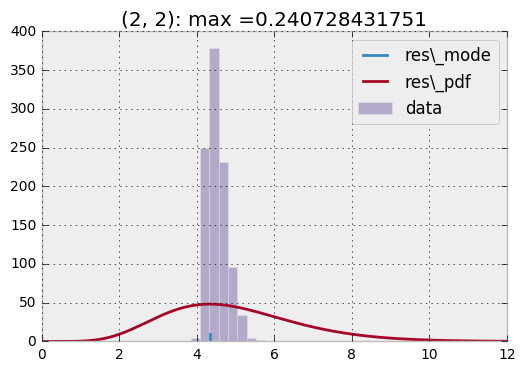

In [15]:
alpha_trace = trace.get_values('alpha')
beta_trace = trace.get_values('beta')

burnin = int(.1*len(alpha_trace))

alpha_mean = np.mean(alpha_trace, axis = 0)
alpha_std = np.std(alpha_trace, axis = 0)
assert np.shape(alpha_mean) == (n, n), "Wrong Dimensions"

beta_mean = np.mean(beta_trace, axis = 0)
beta_std = np.std(beta_trace, axis = 0)

mode = (alpha_mean - 1)/beta_mean

# shape
k_mean = alpha_mean
# scale
theta_mean = 1/beta_mean

assert np.shape(theta_mean) == np.shape(beta_mean), "Wrong Dimensions"

bins = 50
maxx = 12

x = np.linspace(0, maxx, 1000)

for i, j in itertools.product(range(n), repeat=2):
    plt.figure()
    m = np.mean(mode[i,j])
    plt.plot([m,m], [10,0])
    res = scipy.stats.gamma.pdf(x=x,
                                a=np.mean(k_mean[i,j]),
                                scale=np.mean(theta_mean[i,j]))
    plt.plot(x, res*200)  
    
    plt.hist(y[:,i,j], bins=bins, range=[0, 12], alpha=.5)
                          
    plt.legend(["res\_mode", 'res\_pdf', 'data'])
    plt.title('('+
              str(i)+
              ", "+
              str(j)+
              '): '+
              'max ='+
              str(np.max(res)))